### import gym 
gym.version.VERSION

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from gridworld_env import GridworldEnv

In [2]:
env = GridworldEnv('') # Number of plan 

['1 1 1 1 1 1 1 1 1 1\n', '1 4 0 1 1 1 1 0 2 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 0 0 0 0 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 5 0 1 1 1 1 0 3 1\n', '1 1 1 1 1 1 1 1 1 1\n']


/Users/maxja/miniconda3/envs/distral/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


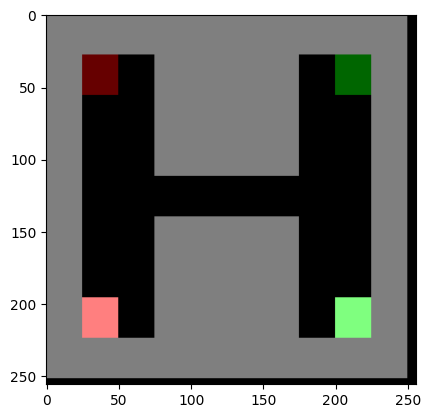

In [3]:
env.render()

In [4]:
env.observation_space

Box(-1.0, 1.0, (3,), float32)

In [5]:
print(env.reset())
print(env.action_space.sample())
env.step(env.action_space.sample(), agent_idx=0)
env.step(env.action_space.sample(), agent_idx=1)

[-0.7777777777777778, 0.0, 0.0, 0.4222222222222223, 0.0, 0.0]
0


(array([-0.77777778,  0.        ,  0.        ,  0.44444444,  4.        ,
        -0.1       ]),
 -0.1,
 False,
 {'success': True})

In [6]:
env.verbose = True
print( env._get_agents_start_target_state())

((1, 1), (1, 8), (7, 1), (7, 8))


In [7]:
env.grid_map_shape

(9, 10)

In [8]:
env.observation_space

Box(-1.0, 1.0, (3,), float32)

In [9]:
env.action_space

Discrete(5)

State 				 - Reward
[-0.57777778  1.         -0.1         0.42222222  0.          0.        ] 			 -0.1
[-0.77777778  0.          0.          0.42222222  3.         -0.6       ] 			 -0.6
[-0.55555556  4.         -0.1         0.42222222  0.          0.        ] 			 -0.1
[-0.77777778  0.          0.          0.42222222  3.         -0.6       ] 			 -0.6
[-0.35555556  1.         -0.1         0.42222222  0.          0.        ] 			 -0.1
[-0.77777778  0.          0.          0.22222222  2.         -0.1       ] 			 -0.1
[-0.35555556  0.         -0.1         0.42222222  0.          0.        ] 			 -0.1
[-0.77777778  0.          0.          0.24444444  4.         -0.1       ] 			 -0.1
[-0.35555556  4.         -0.6         0.42222222  0.          0.        ] 			 -0.6
[-0.77777778  0.          0.          0.44444444  1.         -0.1       ] 			 -0.1
Total episode reward:  -2.5000000000000004


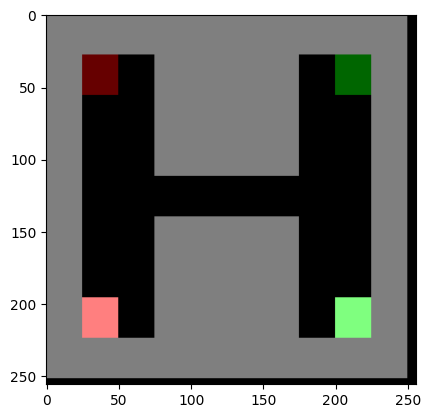

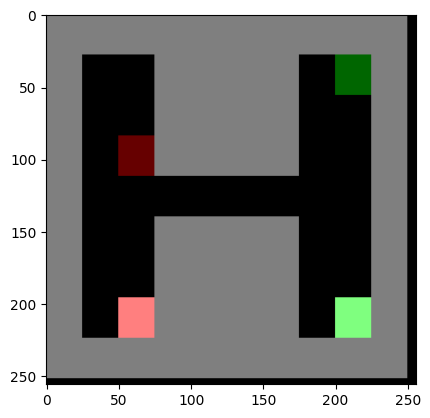

In [10]:
# Try random policy, seems to work
env.reset()
env.render()
print('State \t\t\t\t - Reward')
for i in range(5):
    for agent_idx in range(2):
        move = env.action_space.sample()
        obs , reward, _, _ =  env.step(move, agent_idx) 
        print(obs,'\t\t\t',reward)
        
env.render()
    
print('Total episode reward: ', env.episode_total_reward)

## Q-learning Example

In [11]:
# Q learning params
ALPHA = 0.1 # learning rate
GAMMA = 0.95 # reward discount
LEARNING_COUNT = 1000
TEST_COUNT = 100

TURN_LIMIT = 1000
IS_MONITOR = True

class Agent:
    def __init__(self, env, idx):
        self.env = env
        self.episode_reward = 0.0
        self.q_val = np.zeros(64 * 5).reshape(64, 5).astype(np.float32)
        self.idx = idx

    def learn(self):
        # one episode learning
        state = self.env.reset()
        #self.env.render()
        
        for t in range(TURN_LIMIT):
            act = self.env.action_space.sample() # random
            next_state, reward, done, info = self.env.step(act, self.idx)
            assert len(next_state) == 6
            coords = state[self.idx * 3]
            q_next_max = np.max(self.q_val[int(64.*(coords+1.)/2.)])
            # Q <- Q + a(Q' - Q)
            # <=> Q <- (1-a)Q + a(Q')
            self.q_val[int(64.*(coords+1.)/2.)][act] = (1 - ALPHA) * self.q_val[int(64.*(coords+1.)/2.)][act]\
                                 + ALPHA * (reward + GAMMA * q_next_max)
            
            self.episode_reward += reward
            #self.env.render()
            if done:
                return self.env.episode_total_reward
            else:
                state = next_state
                
        return 0.0 # over limit

    def test(self):
        state = self.env.reset()
        for t in range(TURN_LIMIT):
            norm_coords = state[self.idx * 3]
            act = np.argmax(self.q_val[int(64.*(norm_coords+1.)/2.)])
            next_state, reward, done, info = self.env.step(act, self.idx)
            if done:
                return self.env.episode_total_reward
            else:
                state = next_state
        return 0.0 # over limit

env = GridworldEnv('')
env.reset()
agent1 = Agent(env, 0)
agent2 = Agent(env, 1)

print("###### LEARNING #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(LEARNING_COUNT):
    reward_total_1 += agent1.learn()
    reward_total_2 += agent2.learn()
print("episodes      : {}".format(LEARNING_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / LEARNING_COUNT))
print("agent 1 Q Value       :{}".format(agent1.q_val))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / LEARNING_COUNT))
print("agent 2 Q Value       :{}".format(agent2.q_val))

print("###### TEST #####")
reward_total_1 = 0.0
reward_total_2 = 0.0
for i in range(TEST_COUNT):
    reward_total_1 += agent1.test()
    reward_total_2 += agent2.test()
print("episodes      : {}".format(TEST_COUNT))
print("agent 1 total reward  : {}".format(reward_total_1))
print("agent 1 average reward: {:.2f}".format(reward_total_1 / TEST_COUNT))
print("agent 2 total reward  : {}".format(reward_total_2))
print("agent 2 average reward: {:.2f}".format(reward_total_2 / TEST_COUNT))



['1 1 1 1 1 1 1 1 1 1\n', '1 4 0 1 1 1 1 0 2 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 0 0 0 0 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 0 0 1 1 1 1 0 0 1\n', '1 5 0 1 1 1 1 0 3 1\n', '1 1 1 1 1 1 1 1 1 1\n']
###### LEARNING #####
episodes      : 1000
agent 1 total reward  : -81017.39999999935
agent 1 average reward: -81.02
agent 1 Q Value       :[[ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [-1.9999881 -1.9999881 -2.4999876 -2.142118  -2.1281824]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.       ]
 [ 0.         0.         0.         0.         0.     

In [12]:
Q_a1 = agent1.q_val 
policy_function1 = np.argmax( Q_a1 , axis = 1).reshape(8,8)

Q_a2 = agent2.q_val 
policy_function2 = np.argmax( Q_a2 , axis = 1).reshape(8,8)

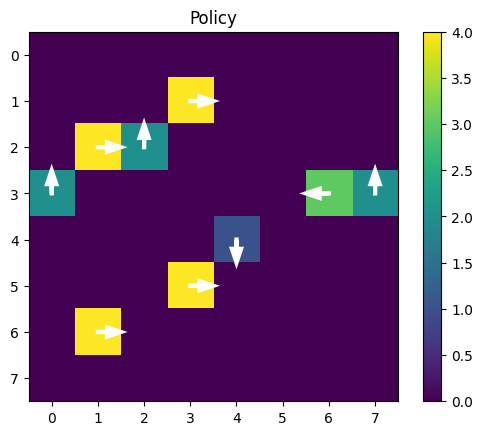

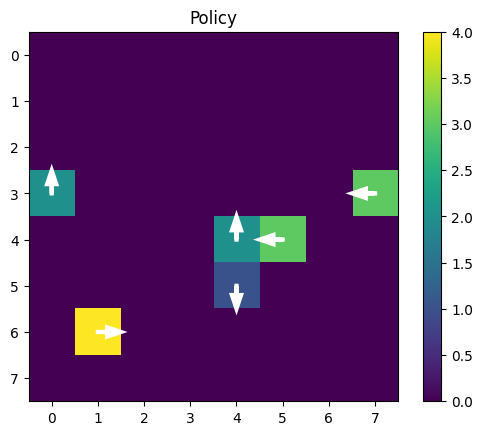

In [13]:
def plot_policy( policy_function ):

    plt.figure()
    plt.imshow( policy_function , interpolation='none' )
    plt.colorbar()

    for row in range( policy_function.shape[0] ):
        for col in range( policy_function.shape[1] ):
            if policy_function[row][col] == 0:
                continue 
            if policy_function[row][col] == 1:
                dx = 0; dy = .5
            if policy_function[row][col] == 2:
                dx = 0; dy = -.5
            if policy_function[row][col] == 3:
                dx = -.5; dy = 0
            if policy_function[row][col] == 4:
                dx = .5; dy = 0
            plt.arrow( col , row , dx , dy , shape='full', fc='w' , ec='w' , lw=3, length_includes_head=True, head_width=.2 )
    plt.title( 'Policy' )        
    plt.show() 
plot_policy(policy_function1)
plot_policy(policy_function2)

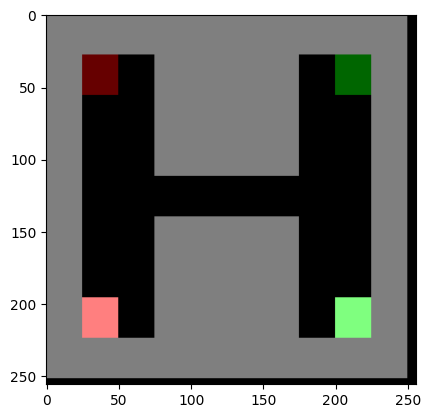

In [14]:
env.reset()
env.render()